Libraries

In [5]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import box
import folium

import yellow.trajectories as traj

Trips

In [6]:
trips = pd.read_csv('../../../yellow/saida.csv')

Trajectories

In [7]:
trajectories = traj.process_trajectories(trips)

/home/higor/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


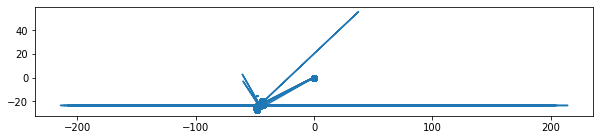

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
trajectories.plot(ax=ax)
plt.show()

A reasonable bounding box

In [9]:
limit = gpd.GeoDataFrame(geometry=[box(-75, -40, -5, +20)])
selected = gpd.sjoin(trajectories, limit, op='within')
len(trips), len(trajectories), len(selected)

/home/higor/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(+init=epsg:4326 +type=crs != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


(427026, 427026, 423626)

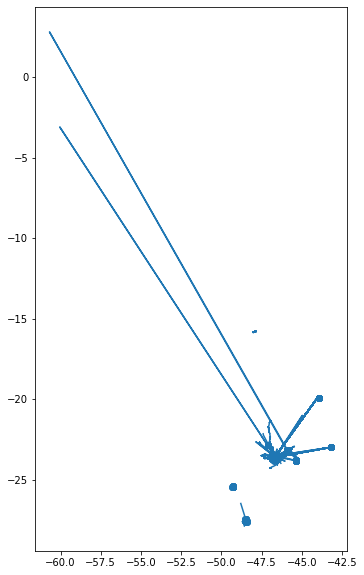

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
selected.plot(ax=ax)
plt.show()

* A little more zoom

In [7]:
limit = gpd.GeoDataFrame(geometry=[box(-52, -40, -41, -14)])
selected = gpd.sjoin(trajectories, limit, op='within')
selected.drop(columns=['index_right'], inplace=True)
len(trips), len(trajectories), len(selected)

(427026, 427026, 423624)

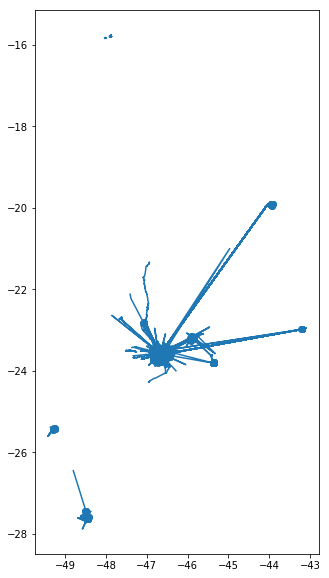

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
selected.plot(ax=ax)
plt.show()

We already have some trip chunks far from São Paulo.

In [9]:
not_sp_areas = [
    gpd.GeoDataFrame(geometry=[box(-49, -17, -47, -15)]),
    gpd.GeoDataFrame(geometry=[box(-45, -21, -43, -19)]),
    gpd.GeoDataFrame(geometry=[box(-44, -24, -43, -22)]),
    gpd.GeoDataFrame(geometry=[box(-50, -26, -48.5, -23)]),
    gpd.GeoDataFrame(geometry=[box(-49, -28, -48, -27)]),
]
not_sp_trips = []
count = 1
for area in not_sp_areas:
    print('Area', count)
    count += 1
    center = area.geometry[0].centroid
    fmap = traj.create_map([center.y, center.x], 7)
    folium.GeoJson(area.to_json()).add_to(fmap)
    trips_in_area = gpd.sjoin(selected, area, op='within')
    folium.GeoJson(trips_in_area[trips_in_area.index == trips_in_area.index[0]].to_json()).add_to(fmap)
    not_sp_trips.append(trips_in_area)
    display(fmap)

Area 1


Area 2


Area 3


Area 4


Area 5


Cities detected

In [10]:
cities = ['Brasília', 'Belo Horizonte', 'Rio de Janeiro', 'Curitiba', 'Florianópolis']
total_length = 0
for i in range(len(cities)):
    print(cities[i] + ':', len(not_sp_trips[i]), 'trips')
    total_length += len(not_sp_trips[i])
    not_sp_trips[i]['city'] = cities[i]
total_length, len(selected)

Brasília: 79 trips
Belo Horizonte: 583 trips
Rio de Janeiro: 1410 trips
Curitiba: 842 trips
Florianópolis: 7389 trips


(10303, 423624)

Trips around São Paulo metropolitan area

In [11]:
sp_metropolitan = gpd.GeoDataFrame(geometry=[box(-48, -25, -45, -22)])
trips_in_sp = gpd.sjoin(selected, sp_metropolitan, op='within')
trips_in_sp.drop(columns=['index_right'], inplace=True)

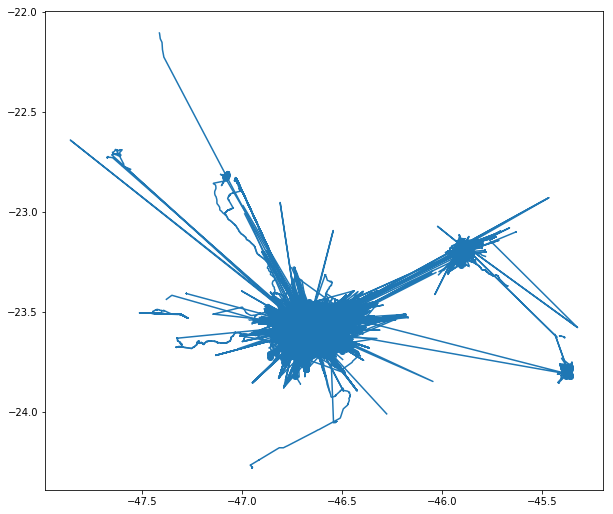

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
trips_in_sp.plot(ax=ax)
plt.show()

In [13]:
sp_areas = [
    gpd.GeoDataFrame(geometry=[box(-48, -23, -47, -22.5)]),
    gpd.GeoDataFrame(geometry=[box(-46.25, -23.5, -45.5, -23)]),
    gpd.GeoDataFrame(geometry=[box(-45.5, -24, -44, -23.5)]),
    gpd.GeoDataFrame(geometry=[box(-47.7, -24, -46.25, -23.25)]),
]
sp_trips = []
count = 1
for area in sp_areas:
    print('Area', count)
    count += 1
    center = area.geometry[0].centroid
    fmap = traj.create_map([center.y, center.x], 7)
    folium.GeoJson(area.to_json()).add_to(fmap)
    trips_in_area = gpd.sjoin(trips_in_sp, area, op='within')
    folium.GeoJson(trips_in_area[trips_in_area.index == trips_in_area.index[0]].to_json()).add_to(fmap)
    sp_trips.append(trips_in_area)
    display(fmap)

Area 1


Area 2


Area 3


Area 4


In [14]:
cities = ['Campinas', 'São José dos Campos', 'São Sebastião', 'São Paulo']
total_length = 0
for i in range(len(cities)):
    print(cities[i] + ':', len(sp_trips[i]), 'trips')
    total_length += len(sp_trips[i])
    sp_trips[i]['city'] = cities[i]
total_length, len(selected)

Campinas: 184 trips
São José dos Campos: 54434 trips
São Sebastião: 539 trips
São Paulo: 358114 trips


(413271, 423624)

Save city info

In [15]:
file = open('../../data/sao-paulo/yellow/cities.csv', 'w')
header = True
for geodf in not_sp_trips + sp_trips:
    geodf[['tripid', 'city']].to_csv(file, header=header)
    header = False
file.close()